In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-02-21/bob_ross.csv"
df = pd.read_csv(url)

print(df.shape)
print(df.columns[:30])

# ---- Identify season column robustly ----
season_col_candidates = [c for c in df.columns if c.lower() in ["season", "series"]]
print("Season candidates:", season_col_candidates)

# Use 'season' if present
season_col = "season" if "season" in df.columns else season_col_candidates[0]
df[season_col] = pd.to_numeric(df[season_col], errors="coerce").astype("Int64")

# ---- Identify color usage columns ----
# Heuristic: binary columns with values in {0,1} and not the season column
binary_cols = []
for c in df.columns:
    if c == season_col:
        continue
    s = df[c].dropna()
    if len(s) == 0:
        continue
    uniq = set(pd.unique(s))
    if uniq.issubset({0, 1}):
        binary_cols.append(c)

print("Binary columns:", len(binary_cols))
print("Example binary cols:", binary_cols[:20])

# Many binary columns include non-color tags; we can separate "color-like" by name pattern
# Bob Ross dataset colors often look like "Titanium_White" etc (with underscore)
color_cols = [c for c in binary_cols if "_" in c]  # simple heuristic
print("Color-like columns:", len(color_cols))
print("Example color cols:", color_cols[:20])


(403, 27)
Index(['painting_index', 'img_src', 'painting_title', 'season', 'episode',
       'num_colors', 'youtube_src', 'colors', 'color_hex', 'Black_Gesso',
       'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow', 'Dark_Sienna',
       'Indian_Red', 'Indian_Yellow', 'Liquid_Black', 'Liquid_Clear',
       'Midnight_Black', 'Phthalo_Blue', 'Phthalo_Green', 'Prussian_Blue',
       'Sap_Green', 'Titanium_White', 'Van_Dyke_Brown', 'Yellow_Ochre',
       'Alizarin_Crimson'],
      dtype='object')
Season candidates: ['season']
Binary columns: 18
Example binary cols: ['Black_Gesso', 'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow', 'Dark_Sienna', 'Indian_Red', 'Indian_Yellow', 'Liquid_Black', 'Liquid_Clear', 'Midnight_Black', 'Phthalo_Blue', 'Phthalo_Green', 'Prussian_Blue', 'Sap_Green', 'Titanium_White', 'Van_Dyke_Brown', 'Yellow_Ochre', 'Alizarin_Crimson']
Color-like columns: 18
Example color cols: ['Black_Gesso', 'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow', 'Dark_Sienna', 'Indian_Red', 'India

# EDA Q3–1 Do different seasons use different numbers of colors?

This checks whether seasonal style variation appears at the surface level through palette complexity differences. If palette size differs across seasons, this suggests temporal variation in color richness and instructional style emphasis.

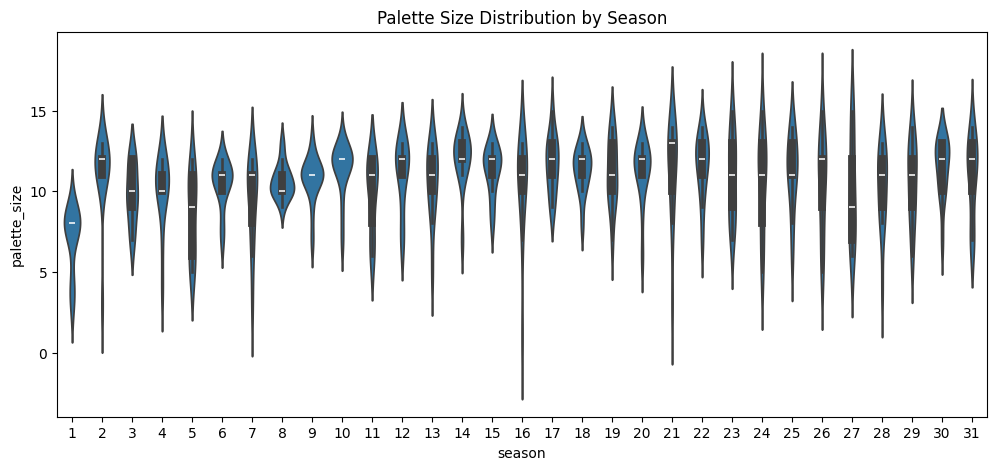

             mean       std  median  min  max
season                                       
1        7.076923  1.977437     8.0    3    9
2       11.153846  2.511512    12.0    3   13
3        9.846154  1.818706    10.0    7   12
4       10.000000  2.236068    10.0    4   12
5        8.538462  2.503843     9.0    5   12
6       10.461538  1.450022    11.0    7   12
7        9.384615  2.693772    11.0    3   12
8       10.615385  1.043908    10.0    9   13
9       10.769231  1.423250    11.0    7   13
10      11.384615  1.609268    12.0    7   13
11       9.846154  2.303843    11.0    6   12
12      11.076923  2.100061    12.0    7   13
13      10.538462  2.258886    11.0    5   13
14      12.000000  1.732051    12.0    7   14
15      11.307692  1.493576    12.0    8   13
16      10.307692  3.250247    11.0    1   13
17      11.692308  1.750458    12.0    9   15
18      11.307692  1.377474    12.0    8   13
19      11.153846  2.075498    11.0    7   14
20      11.230769  1.877669    12.

In [17]:
# Define color_usage_rate and keep_colors (restoring previous definitions)
color_usage_rate = df[color_cols].mean().sort_values(ascending=False)
min_usage = 0.02  # Restoring the previous threshold
keep_colors = color_usage_rate[color_usage_rate >= min_usage].index.tolist()

df["palette_size"] = df[keep_colors].sum(axis=1)

plt.figure(figsize=(12,5))
sns.violinplot(data=df, x=season_col, y="palette_size")
plt.title("Palette Size Distribution by Season")
plt.show()

season_stats = df.groupby(season_col)["palette_size"].agg(
    ["mean","std","median","min","max"]
)
print(season_stats)

The palette size distribution by season shows a clear structural pattern. In most seasons, palette complexity is very stable, with typical paintings using about 11–12 colors, suggesting a consistent core palette grammar rather than large seasonal shifts in average complexity. The main difference across seasons appears in spread rather than the center: some seasons have tighter ranges, while others show wider variation, indicating different levels of internal style flexibility. Season 1 stands out with much simpler palettes, suggesting an early-stage style regime. Later seasons also reach higher maximum palette sizes, implying that the upper bound of complexity expands over time. Overall, seasonal style change is reflected more in variation range than in average palette size, which supports using cluster and distribution-based style analysis.

# EDA Q3–2 Are core color usage patterns consistent across seasons?

I analyze season-level core color usage profiles to test whether seasonal style differences appear as structured shifts in feature usage rather than random variation.

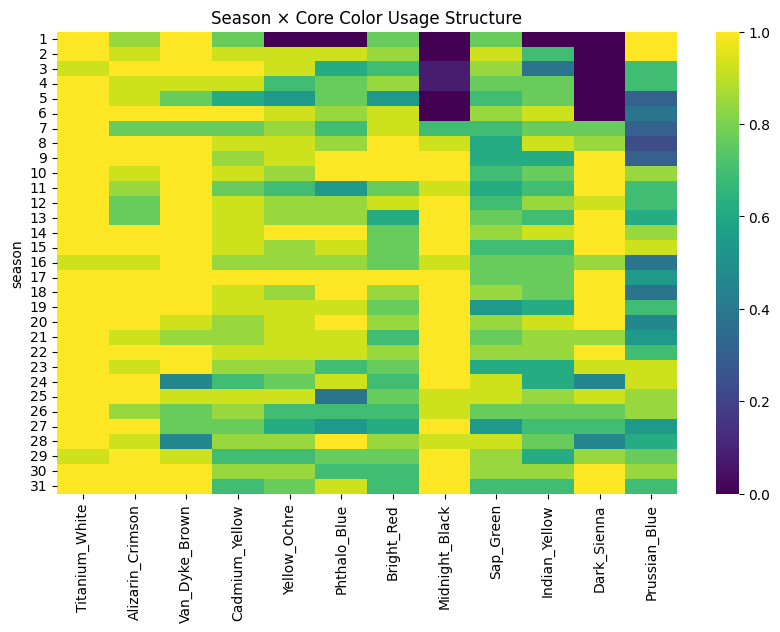

In [18]:
top_colors = color_usage_rate.head(12).index

season_color_profile = df.groupby(season_col)[top_colors].mean()

plt.figure(figsize=(10,6))
sns.heatmap(season_color_profile, cmap="viridis")
plt.title("Season × Core Color Usage Structure")
plt.show()


# EDA Q3–3 Does the frequency of use of the core color change with the seasons?

This analysis examines whether the usage frequency of core colors remains stable across seasons. By tracking how often the most frequently used colors appear in each season, we aim to understand whether Bob Ross’s visual style is temporally consistent or whether subtle shifts in palette preferences occur over time. This helps assess whether stylistic consistency is maintained across episodes or gradually evolves throughout the series.

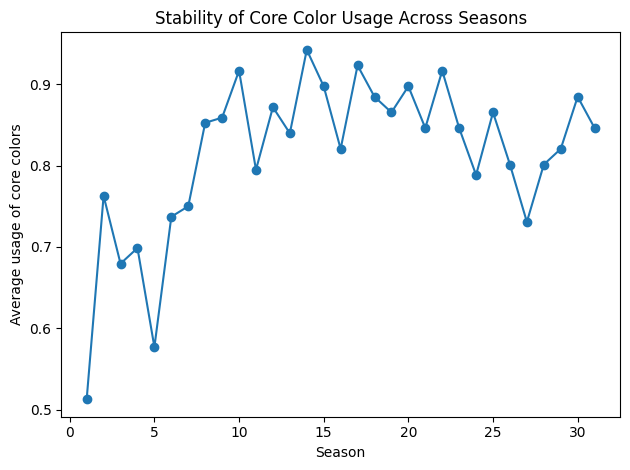

In [19]:
# Define core_colors based on top usage rate
core_colors = color_usage_rate.head(12).index

# Calculate average usage rate of core colors for each season
season_core_usage = (
    df
    .groupby("season")[core_colors]
    .mean()
    .mean(axis=1)
)
# Plot how core color usage changes across seasons
plt.figure()
season_core_usage.plot(marker="o")
plt.xlabel("Season")
plt.ylabel("Average usage of core colors")
plt.title("Stability of Core Color Usage Across Seasons")
plt.tight_layout()
plt.show()

# EDA Q3–4 Which seasons are more likely to deviate from the typical style?

I examine which seasons deviate most from the typical Bob Ross style by measuring each painting’s distance from the global palette feature center. Larger average distances indicate greater style deviation rather than routine variation. This helps identify seasons that represent broader experimentation or reduced palette consistency.

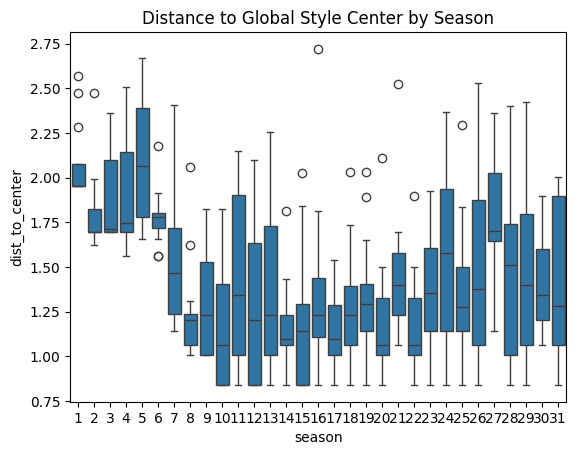

In [20]:
X = df[keep_colors].values
center = X.mean(axis=0)

df["dist_to_center"] = np.linalg.norm(X-center, axis=1)

sns.boxplot(data=df, x=season_col, y="dist_to_center")
plt.title("Distance to Global Style Center by Season")
plt.show()


The results show a clear seasonal pattern in style difference. Early seasons (about Seasons 1–5) have larger and more spread-out distances, meaning paintings in this period differ more from the typical palette pattern. Middle seasons are the most stable, with smaller distances and tighter ranges, suggesting a consolidated core style. Later seasons become more spread out again, showing greater variation rather than a shift in the main style. Overall, seasonal change appears more in how much styles vary than in where the style center sits, which supports using distribution and clustering methods for seasonal style analysis.

# EDA Q3–5 What exactly makes high-deviation paintings different from the typical style profile?

I examine whether paintings from different seasons naturally occupy different regions in the overall style feature space. By projecting high-dimensional color usage features into a low-dimensional manifold using UMAP, this visualization tests whether seasonal style differences appear as spatial separation or density patterns rather than only numerical summary differences. If seasons cluster in different regions, it suggests structured seasonal style segmentation; if they overlap heavily, it suggests a shared global style grammar with distributional variation.

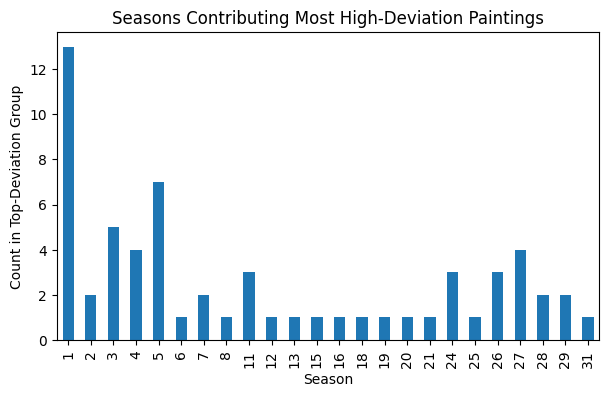

In [21]:
# top deviation threshold
thr = df["dist_to_center"].quantile(0.85)

top_dev = df[df["dist_to_center"] >= thr]

season_counts = top_dev[season_col].value_counts().sort_index()

plt.figure(figsize=(7,4))
season_counts.plot(kind="bar")
plt.title("Seasons Contributing Most High-Deviation Paintings")
plt.xlabel("Season")
plt.ylabel("Count in Top-Deviation Group")
plt.show()

# EDA Q3–6 Which color features most strongly differentiate high-deviation paintings from the typical style profile?

To better understand what drives style deviation, I compare the feature profile of the typical style (global palette center) with the average feature profile of high-deviation paintings. Rather than only measuring distance, this visualization shows which color features contribute most to deviation structure.

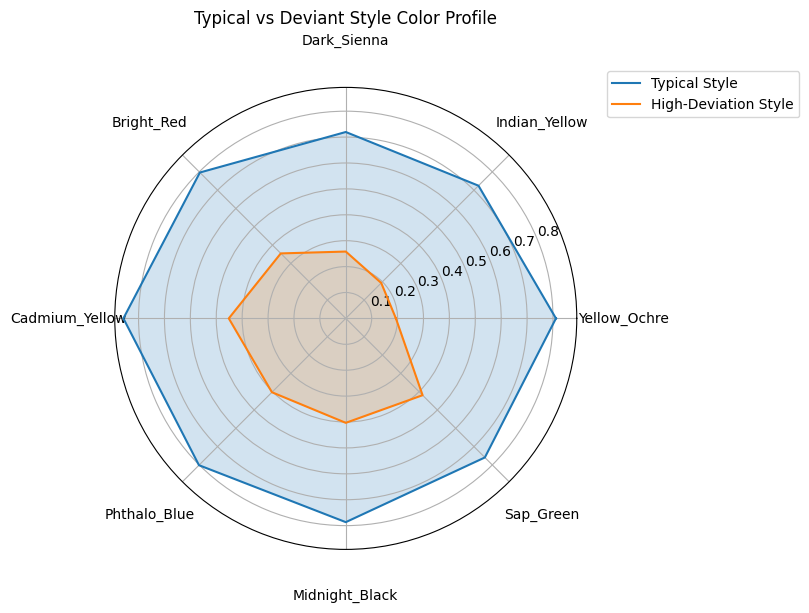

In [22]:
# top 15% deviation paintings
thr = df["dist_to_center"].quantile(0.85)
dev_df = df[df["dist_to_center"] >= thr]

typical_profile = df[keep_colors].mean()
deviant_profile = dev_df[keep_colors].mean()

# Choose the color with the highest distinctiveness
diff = (deviant_profile - typical_profile).abs()
top_features = diff.sort_values(ascending=False).head(8).index.tolist()

typ_vals = typical_profile[top_features].values
dev_vals = deviant_profile[top_features].values

labels = top_features
N = len(labels)

angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]

typ_vals = np.concatenate([typ_vals, [typ_vals[0]]])
dev_vals = np.concatenate([dev_vals, [dev_vals[0]]])

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

ax.plot(angles, typ_vals, label="Typical Style")
ax.fill(angles, typ_vals, alpha=0.2)

ax.plot(angles, dev_vals, label="High-Deviation Style")
ax.fill(angles, dev_vals, alpha=0.2)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.tick_params(axis='x', pad=23)

plt.title("Typical vs Deviant Style Color Profile", y=1.12)
plt.legend(
    loc="upper left",
    bbox_to_anchor=(1.05, 1.05)
)
plt.show()

The radar comparison shows that high-deviation paintings differ from the typical style through systematic palette reweighting rather than isolated color changes. Usage rates are lower across nearly all core colors, with the largest gaps appearing in warm earth tones such as Yellow Ochre, Indian Yellow, Dark Sienna, and Cadmium Yellow. This suggests that style deviation is driven primarily by reduced reliance on the dominant warm palette foundation rather than random variation. In contrast, cooler structural colors such as greens and blues show relatively smaller proportional drops, indicating partial retention of landscape structure. Overall, deviation is characterized by coordinated palette down-weighting of core warm tones, supporting a structured interpretation of style drift rather than noise.

# Data Structure Sanity Check and Season Coverage Verification

This block performs an initial sanity check of the dataset before EDA and unsupervised analysis. It verifies the dataset size (rows and columns), previews the first set of column names to understand available features, and confirms the coverage and range of the season variable. This step ensures that the dataset structure matches expectations and that all seasons are properly represented before feature engineering and clustering steps.

In [23]:
print(df.shape)
# Preview the first 20 column names to understand available fields
print(df.columns[:20])
# Check which season values are present in the dataset
print("season unique:", sorted(df["season"].dropna().unique())[:10], "...",
      sorted(df["season"].dropna().unique())[-5:])

(403, 29)
Index(['painting_index', 'img_src', 'painting_title', 'season', 'episode',
       'num_colors', 'youtube_src', 'colors', 'color_hex', 'Black_Gesso',
       'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow', 'Dark_Sienna',
       'Indian_Red', 'Indian_Yellow', 'Liquid_Black', 'Liquid_Clear',
       'Midnight_Black', 'Phthalo_Blue'],
      dtype='object')
season unique: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)] ... [np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31)]


The results show that there are no missing seasons, the season distribution is complete, and it is safe to perform: season vs cluster, season vs deviation, and season vs distribution.

# Color Feature Identification for Unsupervised Style Analysis

I automatically detected all binary (0/1) indicator columns and filtered them to color-related variables. This produces a clean palette usage feature set representing whether each color is used in each painting. These binary palette indicators form the core feature matrix for subsequent unsupervised clustering and style deviation analysis.

In [24]:
# Identify columns that only contain 0/1
binary_cols = []

for c in df.columns:
    if c == "season":
        continue
    s = df[c].dropna()
    if len(s) > 0 and set(pd.unique(s)).issubset({0, 1}):
        binary_cols.append(c)

print("Binary columns found:", len(binary_cols))
print(binary_cols)

Binary columns found: 18
['Black_Gesso', 'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow', 'Dark_Sienna', 'Indian_Red', 'Indian_Yellow', 'Liquid_Black', 'Liquid_Clear', 'Midnight_Black', 'Phthalo_Blue', 'Phthalo_Green', 'Prussian_Blue', 'Sap_Green', 'Titanium_White', 'Van_Dyke_Brown', 'Yellow_Ochre', 'Alizarin_Crimson']


In [25]:
color_cols = [c for c in binary_cols if "_" in c]
print("Color indicator columns:", len(color_cols))
print(color_cols)

Color indicator columns: 18
['Black_Gesso', 'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow', 'Dark_Sienna', 'Indian_Red', 'Indian_Yellow', 'Liquid_Black', 'Liquid_Clear', 'Midnight_Black', 'Phthalo_Blue', 'Phthalo_Green', 'Prussian_Blue', 'Sap_Green', 'Titanium_White', 'Van_Dyke_Brown', 'Yellow_Ochre', 'Alizarin_Crimson']


The above results show that
* All are 0/1
* No non-color fields were mixed in
* Exactly 18 color variables
* Suitable for unsupervised analysis

# Low-frequency color filtering (removing noise features)

Extremely low-frequency color
* It makes a very small contribution to distance/clustering
* But it will increase the noise dimension
* It will make the cluster unstable

In [26]:
color_usage = df[color_cols].mean().sort_values(ascending=False)

print(color_usage)

Titanium_White      0.992556
Alizarin_Crimson    0.942928
Van_Dyke_Brown      0.920596
Cadmium_Yellow      0.858561
Yellow_Ochre        0.811414
Phthalo_Blue        0.801489
Bright_Red          0.796526
Midnight_Black      0.786600
Sap_Green           0.759305
Indian_Yellow       0.724566
Dark_Sienna         0.719603
Prussian_Blue       0.652605
Phthalo_Green       0.287841
Black_Gesso         0.250620
Burnt_Umber         0.136476
Liquid_Clear        0.126551
Liquid_Black        0.034739
Indian_Red          0.002481
dtype: float64


I filtered out extremely low-frequency colors and kept only those used in at least 5% of paintings. Rare colors add dimensional noise but little structural signal in distance-based and clustering analyses. Removing them reduces feature sparsity and improves cluster stability while preserving the core palette structure needed for style segmentation.

In [27]:
min_usage = 0.05

keep_colors = color_usage[color_usage >= min_usage].index.tolist()

print("Kept colors:", len(keep_colors), "/", len(color_cols))
print(keep_colors)

Kept colors: 16 / 18
['Titanium_White', 'Alizarin_Crimson', 'Van_Dyke_Brown', 'Cadmium_Yellow', 'Yellow_Ochre', 'Phthalo_Blue', 'Bright_Red', 'Midnight_Black', 'Sap_Green', 'Indian_Yellow', 'Dark_Sienna', 'Prussian_Blue', 'Phthalo_Green', 'Black_Gesso', 'Burnt_Umber', 'Liquid_Clear']


# Standardize the construction of the clustering feature matrix

In [28]:
from sklearn.preprocessing import StandardScaler

X = df[keep_colors].astype(float).values

scaler = StandardScaler()
Xz = scaler.fit_transform(X)

print("Feature matrix shape:", X.shape)
print("After scaling: mean ~", Xz.mean().round(4), "std ~", Xz.std().round(4))

Feature matrix shape: (403, 16)
After scaling: mean ~ -0.0 std ~ 1.0


# K-Means

    k  silhouette      inertia
0   2    0.312817  5330.350649
1   3    0.308481  4448.093835
2   4    0.311924  4043.014125
3   5    0.274216  3710.998592
4   6    0.283518  3408.007914
5   7    0.249270  3167.365244
6   8    0.255261  3016.257905
7   9    0.276520  2701.652720
8  10    0.295307  2546.315296


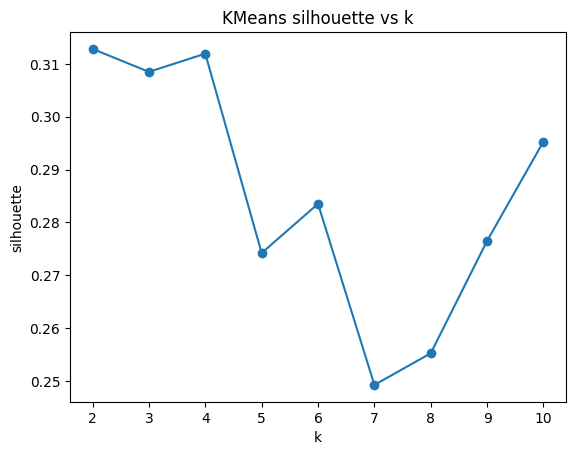

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

rows = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(Xz)
    sil = silhouette_score(Xz, labels)
    rows.append((k, sil, km.inertia_))

import pandas as pd
results_k = pd.DataFrame(rows, columns=["k","silhouette","inertia"])
print(results_k)

import matplotlib.pyplot as plt
plt.plot(results_k["k"], results_k["silhouette"], marker="o")
plt.title("KMeans silhouette vs k")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.show()

I tested KMeans with k from 2 to 10 and evaluated cluster quality using silhouette scores. While k=2 and k=4 achieved the highest scores, k=2 produced overly coarse segmentation with limited interpretability. We selected k=4 as a better balance between cluster quality and style granularity, allowing meaningful style segments while maintaining stable separation.

# Label the season distribution chart with k=4

cluster    0         1         2         3
season                                    
1        0.0  0.769231  0.230769  0.000000
2        0.0  0.923077  0.076923  0.000000
3        0.0  0.923077  0.000000  0.076923
4        0.0  0.846154  0.153846  0.000000
5        0.0  0.692308  0.307692  0.000000


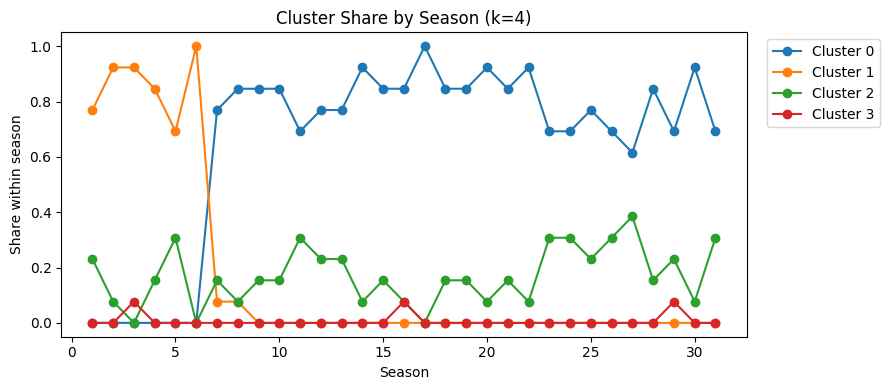

In [30]:
from sklearn.cluster import KMeans

k_best = 4

km = KMeans(n_clusters=k_best, random_state=42, n_init=20)
df["cluster"] = km.fit_predict(Xz).astype(str)

# season × cluster 占比
ct = pd.crosstab(df["season"], df["cluster"], normalize="index")
print(ct.head())

import matplotlib.pyplot as plt

plt.figure(figsize=(9,4))
for c in ct.columns:
    plt.plot(ct.index, ct[c], marker="o", label=f"Cluster {c}")

plt.title("Cluster Share by Season (k=4)")
plt.xlabel("Season")
plt.ylabel("Share within season")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

We applied KMeans clustering to the filtered color usage features and evaluated cluster solutions from k=2 to k=10 using silhouette scores. While k=2 and k=4 achieved the highest scores, we selected k=4 to obtain more interpretable style segmentation without sacrificing cluster quality. The resulting cluster-by-season distribution reveals clear temporal structure rather than uniform mixing. Early seasons (1–6) are dominated by a single cluster, indicating a highly consistent palette structure. Around season 7, there is a visible regime shift, with a different cluster becoming dominant across many subsequent seasons. In later seasons, cluster composition becomes more mixed, with a secondary cluster contributing a larger share, suggesting increasing palette diversity and stylistic flexibility. This pattern indicates that seasonal differences are not random fluctuations but reflect structured shifts in palette style composition over time.

# Calculate the "Typical style center"

In [31]:
# Use the standardized feature matrix
style_center = Xz.mean(axis=0)

print("Style center vector length:", len(style_center))

Style center vector length: 16


# Calculate the deviation distance of each painting

In [32]:
dist = np.linalg.norm(Xz - style_center, axis=1)

df["style_deviation"] = dist

print(df["style_deviation"].describe())

count    403.000000
mean       3.697117
std        1.528766
min        1.996626
25%        2.460990
50%        3.431946
75%        4.499773
max       13.536029
Name: style_deviation, dtype: float64


# Look at deviation's biggest painting

In [33]:
df.sort_values("style_deviation", ascending=False)[
    ["painting_title","season","style_deviation"]
].head(10)

,painting_title,season,style_deviation
200,Contemplative Lady,16,13.536029
373,Pot O' Posies,29,13.025674
35,Campfire,3,12.637343
63,Indian Girl,5,7.766533
337,Evening at the Falls,26,7.570627
331,Snow Birch,26,7.528269
269,Blue Winter,21,7.526270
42,Winter Sawscape,4,7.476965
359,Winter's Grace,28,7.270138
5,Winter Moon,1,7.155952


To quantify stylistic deviation without supervision, we computed each painting’s distance to the global style center in the standardized color-feature space. This center represents the typical palette usage profile across all paintings. Euclidean distance from this center serves as a style deviation score. The deviation distribution is strongly right-skewed, with a small number of paintings showing extremely large distances relative to the median, indicating the presence of rare palette configurations rather than uniform variation. The highest-deviation paintings appear across early, middle, and late seasons, suggesting that style outliers are episodic and theme-driven rather than confined to a single time period.

In [34]:
season_dev = (
    df.groupby("season")["style_deviation"]
      .agg(["mean","median","max","count"])
)

print(season_dev.head())

            mean    median        max  count
season                                      
1       5.131630  4.664598   7.155952     13
2       4.534798  4.221039   6.967926     13
3       5.172114  4.242370  12.637343     13
4       4.698277  4.377604   7.476965     13
5       5.292999  5.221727   7.766533     13


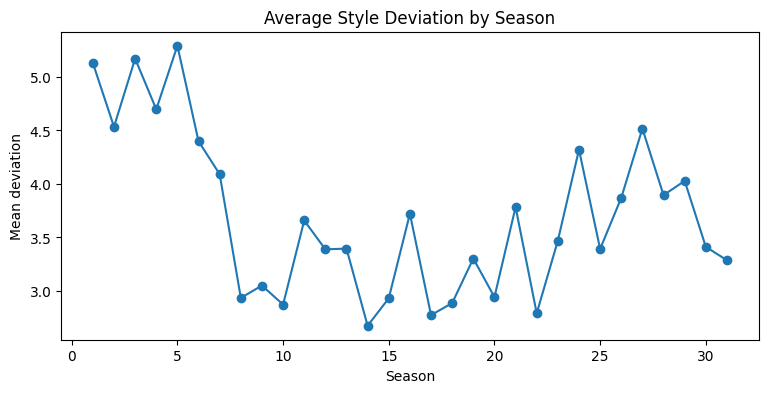

In [35]:
plt.figure(figsize=(9,4))
plt.plot(season_dev.index, season_dev["mean"], marker="o")
plt.title("Average Style Deviation by Season")
plt.xlabel("Season")
plt.ylabel("Mean deviation")
plt.show()

I computed each painting’s distance to the global palette center to quantify style deviation and then aggregated deviation scores by season. The results show a clear temporal pattern. Early seasons exhibit substantially higher average deviation, indicating more experimental or less standardized palette structures. Mid-series seasons show the lowest deviation levels, suggesting a consolidation phase where palette usage becomes more stable and representative of the typical style profile. In later seasons, average deviation rises again, reflecting increased palette diversity and stylistic variation.